# Preparasion

In [1]:
from information_tools import entropy, jEntropy, cEntropy, Mutual_Info
from common_tools import discretization
import numpy as np

# Calculating I(X,T) and I(T,Y)
def information_plane(X,Y,activations_list, layers, EPOCHS):

    I_XT = np.zeros((len(layers),EPOCHS))
    I_TY = np.zeros((len(layers),EPOCHS))

    for layer in range(0,len(layers)):
        for epoch in range(0,EPOCHS):
            I_XT[layer,epoch] = Mutual_Info(activations_list[epoch][layer][0],X)
            I_TY[layer,epoch] = Mutual_Info(activations_list[epoch][layer][0],Y)

    return I_XT,I_TY

In [2]:
import torch
from utils import get_ib_data

def tensor_casting(dataset):
    return torch.tensor(dataset.X, dtype=torch.float32), \
           torch.tensor(dataset.y, dtype=torch.float32), \
           torch.tensor(dataset.c, dtype=torch.long)

trn, tst = get_ib_data()

x_train, y_train, c_train = tensor_casting(trn)
x_test, y_test, c_test = tensor_casting(tst)

data = dict()
data['train'] = {}
data['train']['samples'] = x_train
data['train']['labels'] = y_train
data['train']['class'] = c_train
data['test'] = {}
data['test']['samples'] = x_test
data['test']['labels'] = y_test
data['test']['class'] = c_test

Loading Data...


In [3]:
import torch


class FeedForward(torch.nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FeedForward, self).__init__()
        torch.manual_seed(1234)
        self.hidden_sizes = list(hidden_sizes)
        self.layers = torch.nn.ModuleList()
        self.hidden_sizes += [output_size]
        self.n_layers = len(hidden_sizes)
        prev = input_size
        for h in self.hidden_sizes:
            self.layers.append(torch.nn.Linear(prev, h))
            prev = h

    def forward(self, x):
        hiddens = []
        for j, layer in enumerate(self.layers):
            if j != (self.n_layers - 1):
                x = torch.tanh(layer(x))
                hiddens.append(x)
            else:
                x = layer(x)
                # hiddens.append(x)
        return x, hiddens

In [4]:
# setup
input_size = 12
output_size = 2
hidden_sizes = [10, 7, 5, 4, 3]
net = FeedForward(input_size, hidden_sizes, output_size)
print(hidden_sizes)

[10, 7, 5, 4, 3]


In [27]:
# training
net = FeedForward(input_size, hidden_sizes, output_size)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)
epochs = 4000
mi_cycle = 40
n_layers = net.n_layers

# recording structure
losses = dict()
accuracy = dict()
running_mis_xt = dict()
running_mis_ty = dict()
for phase in ['train', 'test']:
    losses[phase] = []
    accuracy[phase] = []
    running_mis_xt[phase] = []
    running_mis_ty[phase] = []

# Runing code
for i in range(epochs):
    to_print = ''
    for phase in ['train', 'test']:
        if phase == 'train':
            net.train()
        else:
            net.eval()
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):
            outputs, hiddens = net(data[phase]['samples'])
            loss = criterion(outputs, data[phase]['labels'])
            if phase == 'train':
                loss.backward()
                optimizer.step()
        loss = loss.item()
        losses[phase].append(loss)
        acc = (data[phase]['class'] == outputs.argmax(dim=1)).sum() / float(len(data[phase]['labels']))
        accuracy[phase].append(float(acc))

        to_print += f'{phase}: loss {loss:>.4f} - acc {acc:>.4f} \t'
        # if i % mi_cycle == 0:
        running_mi_xt = []
        running_mi_ty = []
        for j in range(n_layers):
            activity = hiddens[j].detach().numpy()
            bins = np.linspace(-1, 1, 30)
            activity = np.digitize(activity, bins)
            binxm= Mutual_Info(data[phase]['samples'], activity)
            binym= Mutual_Info(data[phase]['labels'], activity)
            running_mi_xt.append(binxm)
            running_mi_ty.append(binym)
        running_mis_xt[phase].append(running_mi_xt)
        running_mis_ty[phase].append(running_mi_ty)

    print(f'Epoch {i:>4}: {to_print}')

Epoch    0: train: loss 0.6969 - acc 0.5215 	test: loss 0.7013 - acc 0.4994 	
Epoch    1: train: loss 0.6969 - acc 0.5215 	test: loss 0.7013 - acc 0.4994 	
Epoch    2: train: loss 0.6969 - acc 0.5215 	test: loss 0.7013 - acc 0.4994 	
Epoch    3: train: loss 0.6969 - acc 0.5215 	test: loss 0.7012 - acc 0.4994 	
Epoch    4: train: loss 0.6968 - acc 0.5215 	test: loss 0.7011 - acc 0.4994 	
Epoch    5: train: loss 0.6968 - acc 0.5215 	test: loss 0.7010 - acc 0.4994 	
Epoch    6: train: loss 0.6967 - acc 0.5215 	test: loss 0.7010 - acc 0.4994 	
Epoch    7: train: loss 0.6966 - acc 0.5215 	test: loss 0.7009 - acc 0.4994 	
Epoch    8: train: loss 0.6966 - acc 0.5215 	test: loss 0.7008 - acc 0.4994 	
Epoch    9: train: loss 0.6965 - acc 0.5215 	test: loss 0.7007 - acc 0.4994 	
Epoch   10: train: loss 0.6964 - acc 0.5215 	test: loss 0.7006 - acc 0.4994 	
Epoch   11: train: loss 0.6963 - acc 0.5215 	test: loss 0.7004 - acc 0.4994 	
Epoch   12: train: loss 0.6962 - acc 0.5215 	test: loss 0.7003 -

In [28]:
print(len(running_mis_xt["train"]))
print(len(running_mis_xt["train"][0]))
print(running_mis_xt["train"][0])

print(Mutual_Info(data["train"]['samples'], data["train"]['labels']))

4000
5
[11.678159957542757, 11.518583224858324, 7.24775580555799, 3.2881819646299384, 0.8543262429126024]
0.9986641307020001


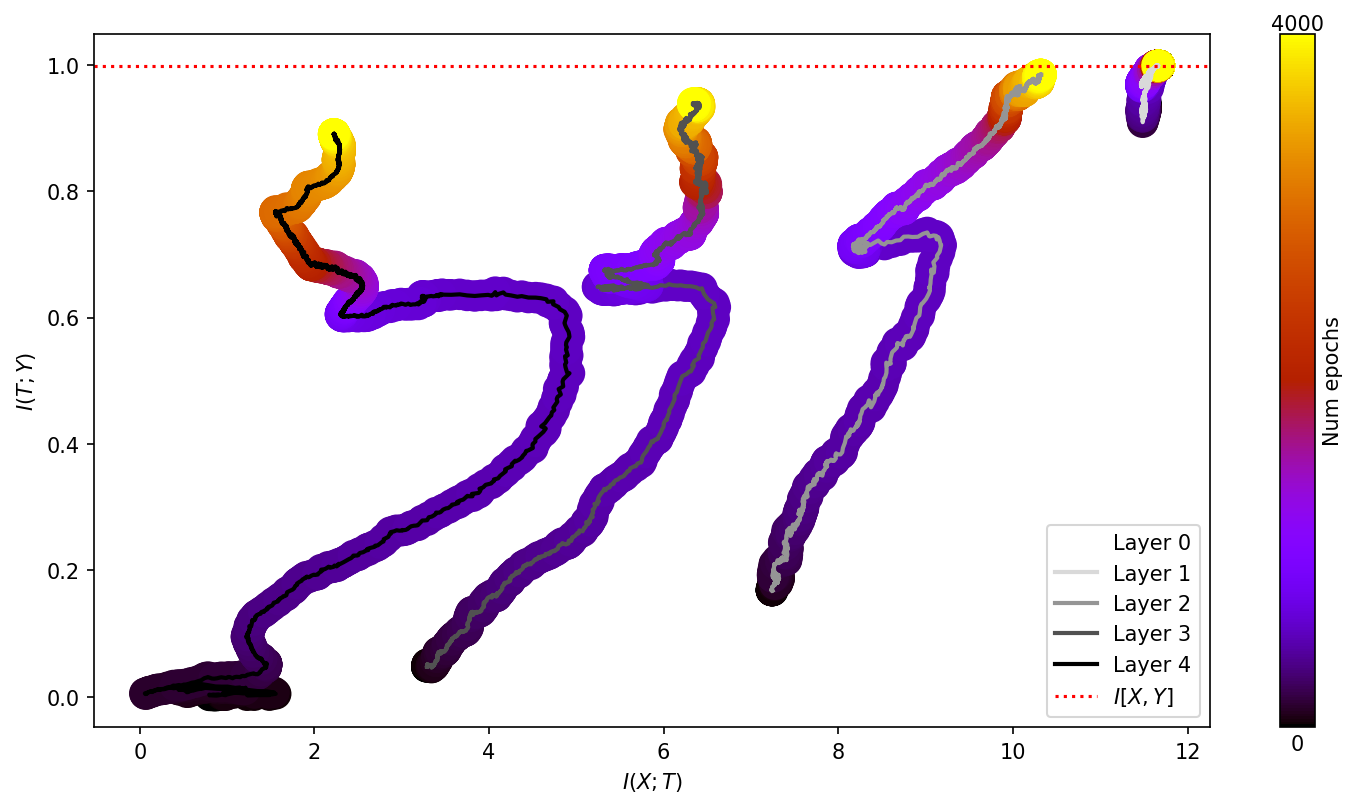

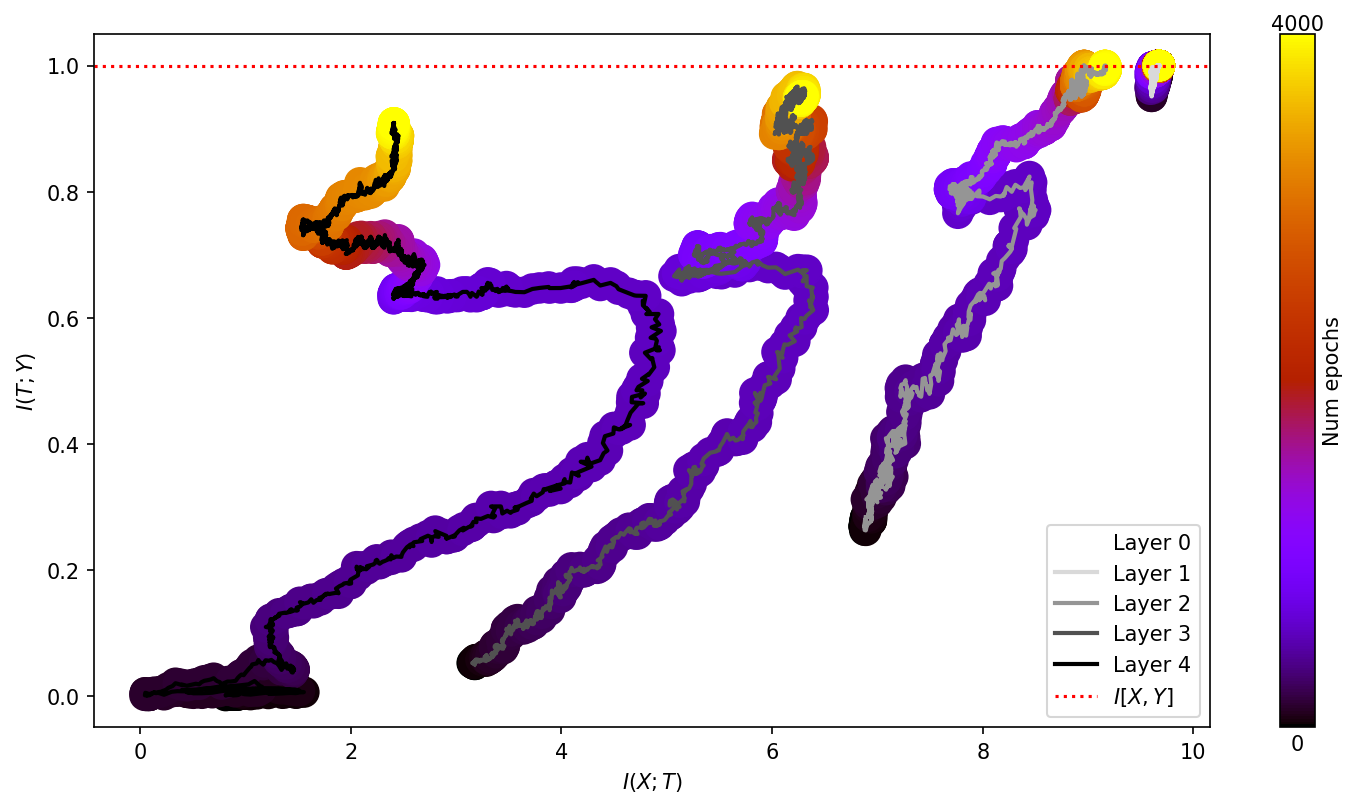

In [37]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

I_XY = Mutual_Info(data["train"]['samples'], data["train"]['labels'])

def plot_information_plane(IXT_array, ITY_array, num_epochs, every_n, I_XY):
    assert len(IXT_array) == len(ITY_array)

    max_index = n_layers

    plt.figure(figsize=(12, 6),dpi=150)
    ax = plt.axes()
    plt.xlabel(r'$I(X;T)$')
    plt.ylabel(r'$I(T;Y)$')


    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, num_epochs)]
    cmap_layer = plt.get_cmap('Greys')
    clayer = [cmap_layer(i) for i in np.linspace(0, 1, max_index)] # obtain color for each layer

    for i in range(0, max_index): # by layers
        IXT = [sub_array[i] for sub_array in IXT_array ]
        ITY = [sub_array[i] for sub_array in ITY_array ]
        plt.plot(IXT,ITY,color=clayer[i],linestyle=None,linewidth=2,label='Layer {}'.format(str(i)))
        plt.scatter(IXT,ITY,marker='o',c=colors,s=200,alpha=1)#,zorder=10)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []
    cbar = plt.colorbar(sm, ax = ax, ticks=[])
    cbar.set_label('Num epochs')
    cbar.ax.text(0.5, -0.01, 0, transform=cbar.ax.transAxes, va='top', ha='center')
    cbar.ax.text(0.5, 1.0, str(num_epochs), transform=cbar.ax.transAxes, va='bottom', ha='center')
    plt.axhline(y = I_XY, color = 'red', linestyle = ':', label=r'$I[X,Y]$')
    plt.legend()
    plt.show()

plot_information_plane(running_mis_xt["train"],running_mis_ty["train"], epochs,1, I_XY)
plot_information_plane(running_mis_xt["test"],running_mis_ty["test"], epochs,1, I_XY)

In [21]:
import random
import numpy as np
# Binarization
def g(x):
    if x < 0:
        return 0
    else:
        return 1

# Gaussian Noise
def f(x):
    y =  100*np.cos(np.sum(x,axis=1)) - np.sum(x,axis=1)**2 + 5*np.random.normal(0,1, 10000)
    return np.array(list(map(g,y)))

#Creating X and Y
x = np.array([[random.randint(0, 1) for i in range(10)] for i in range(10000)])
y = f(x).reshape(-1,1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

input_shape = len(X_train[0])

In [23]:
import numpy as np
# Calculating I(X,T) and I(T,Y)
def information_plane(X,Y,activations_list, layers, EPOCHS):

    I_XT = np.zeros((len(layers),EPOCHS))
    I_TY = np.zeros((len(layers),EPOCHS))
    
    for layer in range(0,len(layers)):
        for epoch in range(0,EPOCHS):
            I_XT[layer,epoch] = Mutual_Info(activations_list[epoch][layer][0],X)
            I_TY[layer,epoch] = Mutual_Info(activations_list[epoch][layer][0],Y)
            
    return I_XT,I_TY
    
# Discretize the continous output of the layers
activations_list = discretization(activations_list,30, layers, EPOCHS)
 # Calculating I(X,T) and I(T,Y)
information_plane = information_plane(X_train,y_train,activations_list, layers, EPOCHS)

NameError: name 'activations_list' is not defined

In [ ]:
import matplotlib.pyplot as plt

def plot_information_plane(IXT_array, ITY_array, num_epochs, every_n, I_XY):
    assert len(IXT_array) == len(ITY_array)

    max_index = len(IXT_array)

    plt.figure(figsize=(12, 6),dpi=150)
    plt.xlabel(r'$I(X;T)$')
    plt.ylabel(r'$I(T;Y)$')

    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, num_epochs)]
    cmap_layer = plt.get_cmap('Greys')
    clayer = [cmap_layer(i) for i in np.linspace(0, 1, max_index)]

    for i in range(0, max_index):
        IXT = IXT_array[i, :]
        ITY = ITY_array[i, :]

        plt.plot(IXT,ITY,color=clayer[i],linestyle=None,linewidth=2,label='Layer {}'.format(str(i)))
        plt.scatter(IXT,ITY,marker='o',c=colors,s=200,alpha=1)#,zorder=10)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []
    cbar = plt.colorbar(sm, ticks=[])
    cbar.set_label('Num epochs')
    cbar.ax.text(0.5, -0.01, 0, transform=cbar.ax.transAxes, va='top', ha='center')
    cbar.ax.text(0.5, 1.0, str(num_epochs), transform=cbar.ax.transAxes, va='bottom', ha='center')
    plt.axhline(y = I_XY, color = 'red', linestyle = ':', label=r'$I[X,Y]$')
    plt.legend()
    plt.show()

plot_information_plane(information_plane[0],information_plane[1],EPOCHS,1, I_XY)

# CNN on MINIST
Now I want to apply IB theory on a more famous but simple work: CNN on MINIST

In [6]:
# define dataset loader
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),

    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x293a3bb8970>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x293b08f7370>}

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])


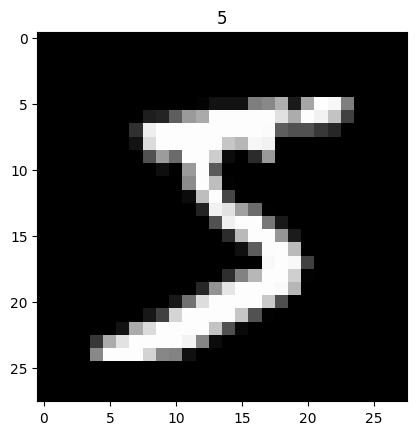

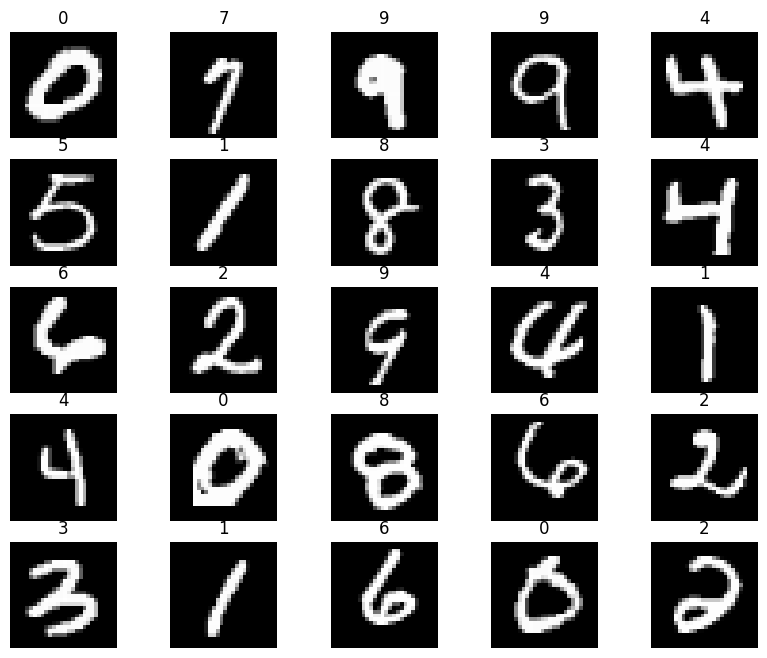

In [5]:
# visualize dataset
import torch

print(train_data)
print(train_data.data.size())

import matplotlib.pyplot as plt
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [20]:
# define model
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        hiddens = []
        x = self.conv1(x)
        hiddens.append(x)
        x = self.conv2(x)
        hiddens.append(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x, hiddens    # return x for visualization

In [16]:
# Training new model
from torch import optim
from torch.autograd import Variable

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(num_epochs, cnn, loaders, loss_func, optimizer):
    cnn.train()
    cnn = cnn.to(device)
    # Train the model
    total_step = len(loaders['train'])
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images).to(device)   # batch x
            b_y = Variable(labels).to(device)   # batch y
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)
            # clear gradients for this training step
            optimizer.zero_grad()
            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
        pass
    pass

In [17]:
import torch

cnn = CNN()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
# Device configuration
num_epochs = 10

train(num_epochs, cnn, loaders, loss_func, optimizer)

Epoch [1/10], Step [100/600], Loss: 0.2846
Epoch [1/10], Step [200/600], Loss: 0.2769
Epoch [1/10], Step [300/600], Loss: 0.1927
Epoch [1/10], Step [400/600], Loss: 0.2129
Epoch [1/10], Step [500/600], Loss: 0.1209
Epoch [1/10], Step [600/600], Loss: 0.1659
Epoch [2/10], Step [100/600], Loss: 0.1056
Epoch [2/10], Step [200/600], Loss: 0.0539
Epoch [2/10], Step [300/600], Loss: 0.1175
Epoch [2/10], Step [400/600], Loss: 0.1393
Epoch [2/10], Step [500/600], Loss: 0.1981
Epoch [2/10], Step [600/600], Loss: 0.0754
Epoch [3/10], Step [100/600], Loss: 0.1511
Epoch [3/10], Step [200/600], Loss: 0.1235
Epoch [3/10], Step [300/600], Loss: 0.1303
Epoch [3/10], Step [400/600], Loss: 0.0665
Epoch [3/10], Step [500/600], Loss: 0.0672
Epoch [3/10], Step [600/600], Loss: 0.0515
Epoch [4/10], Step [100/600], Loss: 0.1495
Epoch [4/10], Step [200/600], Loss: 0.1482
Epoch [4/10], Step [300/600], Loss: 0.1378
Epoch [4/10], Step [400/600], Loss: 0.1711
Epoch [4/10], Step [500/600], Loss: 0.0435
Epoch [4/10

## Test the model

In [19]:
def test(cnn):
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
test(cnn)

Test Accuracy of the model on the 10000 test images: 0.99


# Caculate Information Plane while training CNN on MNIST